In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms, datasets, utils

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from kymatio.torch import Scattering2D


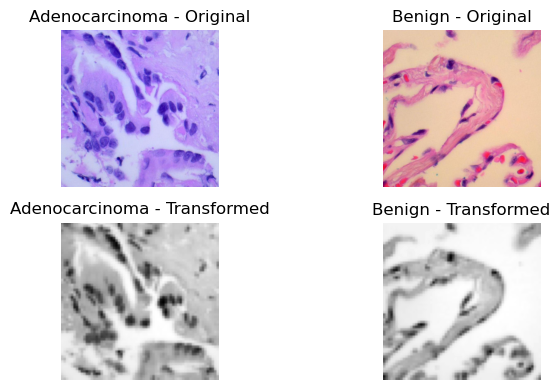

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
IMG_SIZE= 64

# Define paths for training and testing
adenocarcinoma_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma"
benign_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/benign"


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Show one image from each dataset before and after transformation
def show_sample_images():
    adenocarcinoma_files = os.listdir(adenocarcinoma_path)
    benign_files = os.listdir(benign_path)

    # Load one image from each class without transformation
    adenocarcinoma_img = Image.open(os.path.join(adenocarcinoma_path, adenocarcinoma_files[0]))
    benign_img = Image.open(os.path.join(benign_path, benign_files[0]))

    # Apply transformation
    adenocarcinoma_img_transformed = transform(adenocarcinoma_img)
    benign_img_transformed = transform(benign_img)

    # Plot original images
    plt.figure(figsize=(8,4))
    plt.subplot(2,2,1)
    plt.title("Adenocarcinoma - Original")
    plt.imshow(adenocarcinoma_img)
    plt.axis('off')

    plt.subplot(2,2,2)
    plt.title("Benign - Original")
    plt.imshow(benign_img)
    plt.axis('off')

    # Plot transformed images (show as grayscale)
    plt.subplot(2,2,3)
    plt.title("Adenocarcinoma - Transformed")
    plt.imshow(adenocarcinoma_img_transformed.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(2,2,4)
    plt.title("Benign - Transformed")
    plt.imshow(benign_img_transformed.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images()



In [3]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image using PIL
        img = Image.open(img_path)  #

        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
# Step 1: Load full image paths and labels
image_paths = []
labels = []

for filename in os.listdir(adenocarcinoma_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(os.path.join(adenocarcinoma_path, filename))
        labels.append(1)

for filename in os.listdir(benign_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(os.path.join(benign_path, filename))
        labels.append(0)

print(f"Total images loaded: {len(image_paths)}")

# Step 2: Hold out a test set (20%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 3: Create datasets
train_dataset_full = CustomDataset(train_paths, train_labels, transform)  # used for K-Fold
test_dataset = CustomDataset(test_paths, test_labels, transform)          # final hold-out

# Step 4: Final test loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Sanity check
print(f"Train samples: {len(train_dataset_full)}")
print(f"Test samples (held-out): {len(test_dataset)}")


Total images loaded: 10000
Train samples: 8000
Test samples (held-out): 2000


In [5]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Changed input channels to 1
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.feature_size = 64 * (IMG_SIZE // (2**3)) * (IMG_SIZE // (2**3))
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x




In [6]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ImprovedCNN()
model

ImprovedCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ---------------- TRAINING SETUP ----------------
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

Using device: mps


In [12]:
from collections import Counter
print("Train set class distribution:", Counter(train_labels))
print("Test set class distribution:", Counter(test_labels))


Train set class distribution: Counter({0: 4000, 1: 4000})
Test set class distribution: Counter({0: 1000, 1: 1000})


In [8]:
k = 5
epochs = 10
batch_size = 16

# Tracking lists for plotting
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Prepare K-Fold setup
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
all_indices = np.arange(len(train_dataset_full))
all_labels = np.array(train_labels)

fold_accuracies = []
fold_f1s = []

best_f1 = 0.0
best_model_state = None

for fold, (train_idx, val_idx) in enumerate(skf.split(all_indices, all_labels)):
    print(f"\n========== Fold {fold+1}/{k} ==========")

    train_subset = Subset(train_dataset_full, train_idx)
    val_subset = Subset(train_dataset_full, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = ImprovedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_correct = 0
        total_train = 0

        for X_train, y_train in train_loader:
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(y_pred, dim=1)
            train_correct += (predicted == y_train).sum().item()
            total_train += y_train.size(0)
            train_loss_epoch += loss.item() * X_train.size(0)

        avg_train_loss = train_loss_epoch / total_train
        avg_train_acc = train_correct / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # ---- Validation ----
        model.eval()
        val_loss_epoch = 0.0
        val_correct = 0
        total_val = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)

                y_out = model(X_val)
                loss = criterion(y_out, y_val)

                predicted = torch.argmax(y_out, dim=1)
                val_correct += (predicted == y_val).sum().item()
                total_val += y_val.size(0)
                val_loss_epoch += loss.item() * X_val.size(0)

                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(y_val.cpu().numpy())

        avg_val_loss = val_loss_epoch / total_val
        avg_val_acc = val_correct / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
              f"Train Acc={avg_train_acc:.4f}, Val Acc={avg_val_acc:.4f}")

    # Fold-level metrics
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    print(f"Fold {fold+1} Final Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()
        print("Best model updated.")

    # Save per-fold tracking
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

# Save best model
torch.save(best_model_state, "best_kfold_model.pth")
print(" Best K-Fold model saved to 'best_kfold_model.pth'.")

# Final metrics summary
mean_acc = np.mean(fold_accuracies)
mean_f1 = np.mean(fold_f1s)

print("\n========== K-FOLD SUMMARY ==========")
for i, (acc, f1) in enumerate(zip(fold_accuracies, fold_f1s)):
    print(f"Fold {i+1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")



========== Fold 1/5 ==========
Epoch 1: Train Loss=0.3369, Val Loss=0.2890, Train Acc=0.8595, Val Acc=0.9144
Epoch 2: Train Loss=0.1892, Val Loss=0.2034, Train Acc=0.9259, Val Acc=0.9137
Epoch 3: Train Loss=0.1387, Val Loss=0.1149, Train Acc=0.9473, Val Acc=0.9600
Epoch 4: Train Loss=0.1047, Val Loss=0.1877, Train Acc=0.9594, Val Acc=0.9119
Epoch 5: Train Loss=0.0974, Val Loss=0.4663, Train Acc=0.9650, Val Acc=0.7500
Epoch 6: Train Loss=0.0834, Val Loss=0.0349, Train Acc=0.9689, Val Acc=0.9888
Epoch 7: Train Loss=0.0805, Val Loss=0.0395, Train Acc=0.9712, Val Acc=0.9881
Epoch 8: Train Loss=0.0580, Val Loss=0.1909, Train Acc=0.9788, Val Acc=0.9419
Epoch 9: Train Loss=0.0615, Val Loss=2.0470, Train Acc=0.9780, Val Acc=0.5275
Epoch 10: Train Loss=0.0584, Val Loss=0.2377, Train Acc=0.9806, Val Acc=0.9300
Fold 1 Final Accuracy: 0.9300, F1 Score: 0.9297
Best model updated.

========== Fold 2/5 ==========
Epoch 1: Train Loss=0.3137, Val Loss=0.1434, Train Acc=0.8730, Val Acc=0.9406
Epoch 2: 

/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_2441/954711053.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_kfold_mo

Loaded best model from K-Fold.


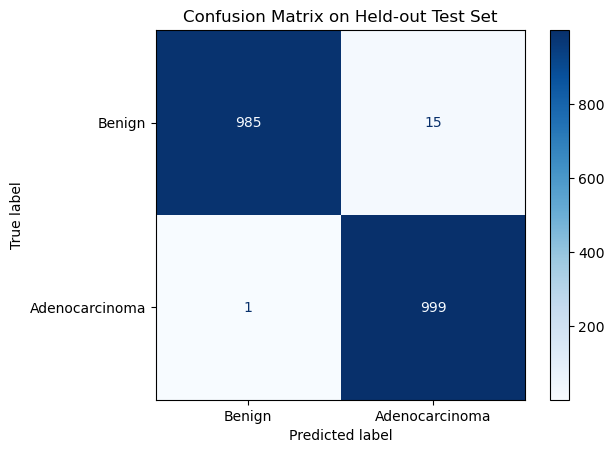


Classification Report:
                precision    recall  f1-score   support

        Benign       1.00      0.98      0.99      1000
Adenocarcinoma       0.99      1.00      0.99      1000

      accuracy                           0.99      2000
     macro avg       0.99      0.99      0.99      2000
  weighted avg       0.99      0.99      0.99      2000



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Load best model saved during K-Fold
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("best_kfold_model.pth"))
model.eval()
print("Loaded best model from K-Fold.")

# Inference on the hold-out test set
all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        outputs = model(X_test)
        predicted = torch.argmax(outputs, dim=1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Adenocarcinoma'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Held-out Test Set")
plt.show()

# Optional: print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Adenocarcinoma']))


In [13]:
print(model)

ImprovedCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [14]:
import matplotlib.pyplot as plt

def visualize_all_conv_outputs(image_tensor, label_name):
    # Send image through conv layers
    x = image_tensor.unsqueeze(0).to(device)  # shape: [1, 1, 64, 64]
    
    model.eval()
    outputs = []
    names = []

    x = model.pool(F.relu(model.bn1(model.conv1(x))))
    outputs.append(x)
    names.append("Conv1")

    x = model.pool(F.relu(model.bn2(model.conv2(x))))
    outputs.append(x)
    names.append("Conv2")

    x = model.pool(F.relu(model.bn3(model.conv3(x))))
    outputs.append(x)
    names.append("Conv3")

    # Show original image
    plt.figure(figsize=(3, 3))
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Original Image - {label_name}")
    plt.axis("off")
    plt.show()

    # Plot each conv layer output
    for idx, feature_map in enumerate(outputs):
        feature_map = feature_map.squeeze(0)  # shape: [C, H, W]
        num_filters = feature_map.shape[0]
        cols = 8
        rows = (num_filters + cols - 1) // cols

        fig = plt.figure(figsize=(15, rows * 2))
        for i in range(num_filters):
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.imshow(feature_map[i].cpu().detach().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'{i}', fontsize=6)

        plt.suptitle(f"{names[idx]} Output: {num_filters} Filters", fontsize=16)
        plt.tight_layout()
        plt.show()


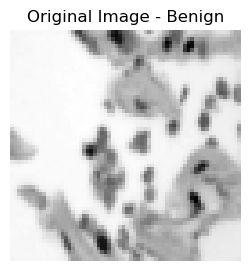

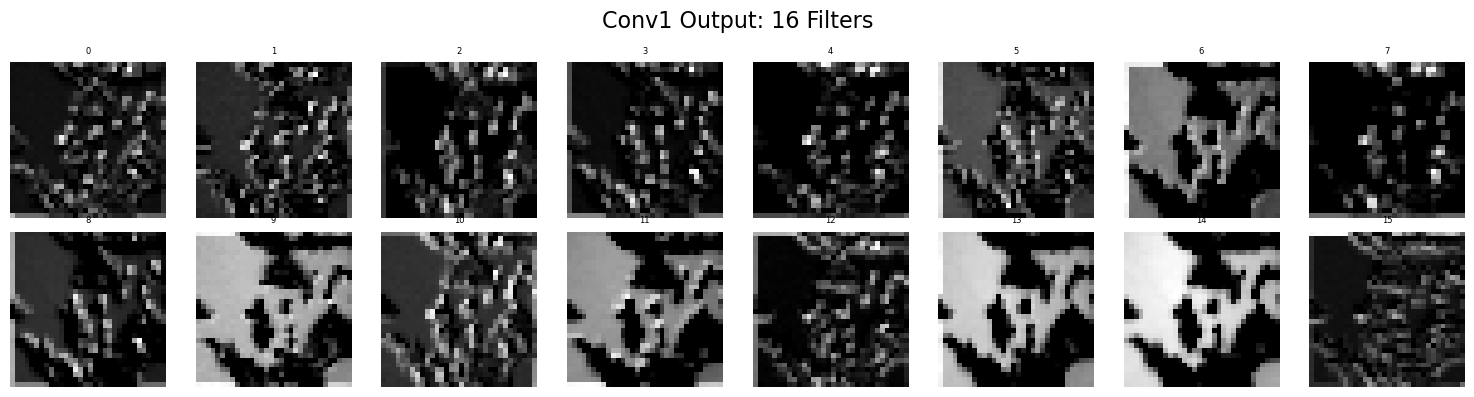

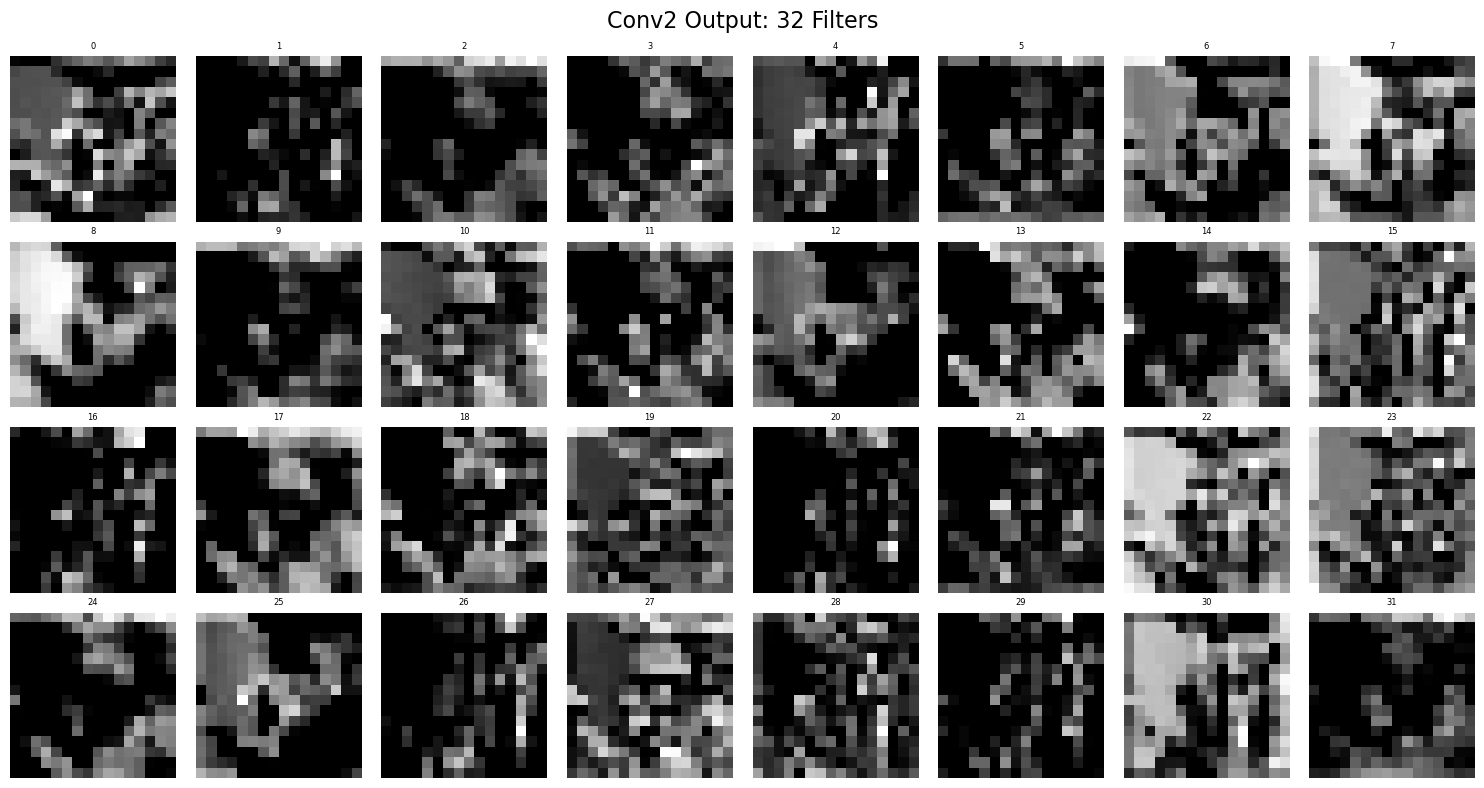

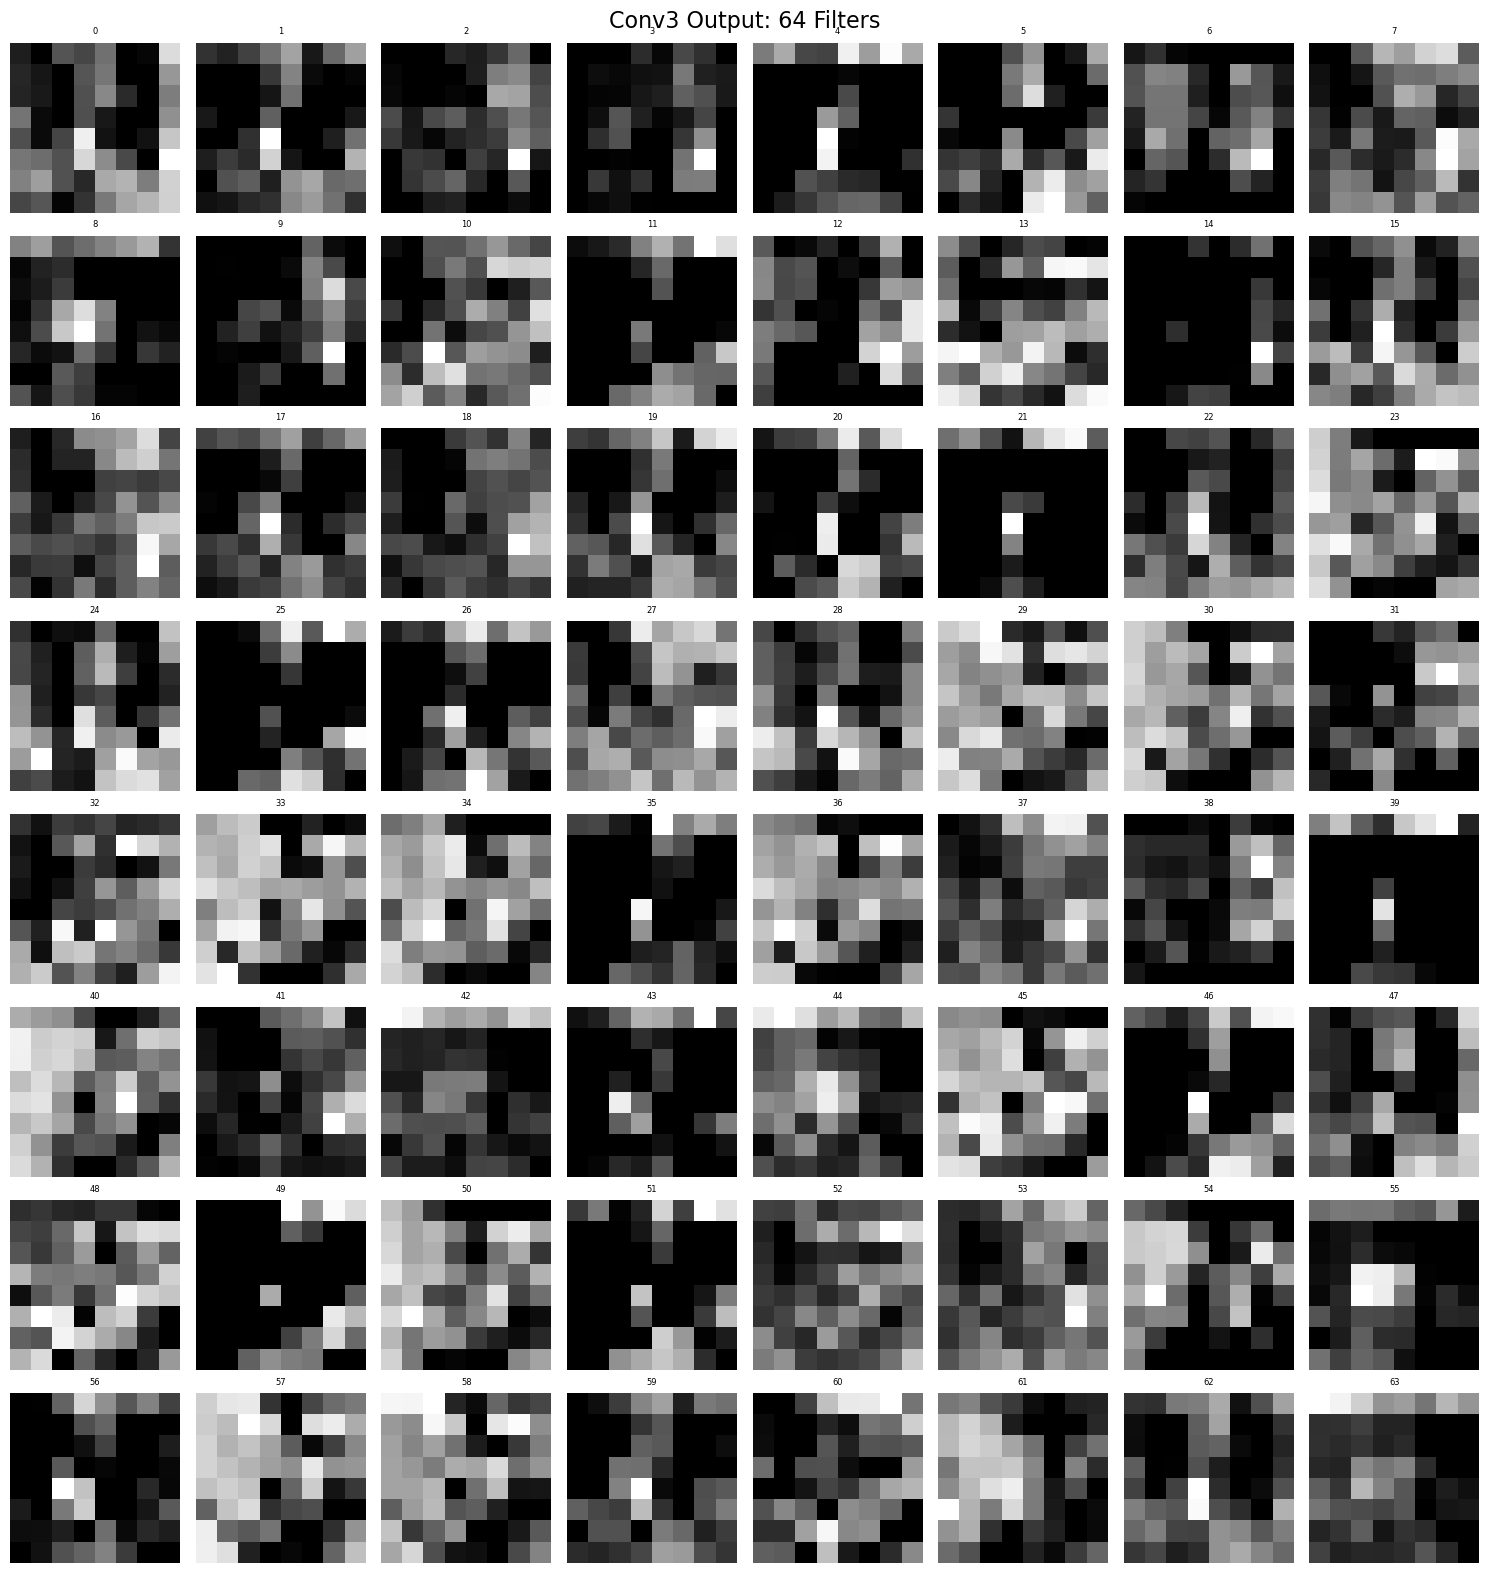

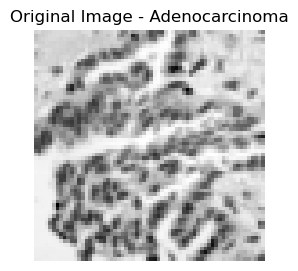

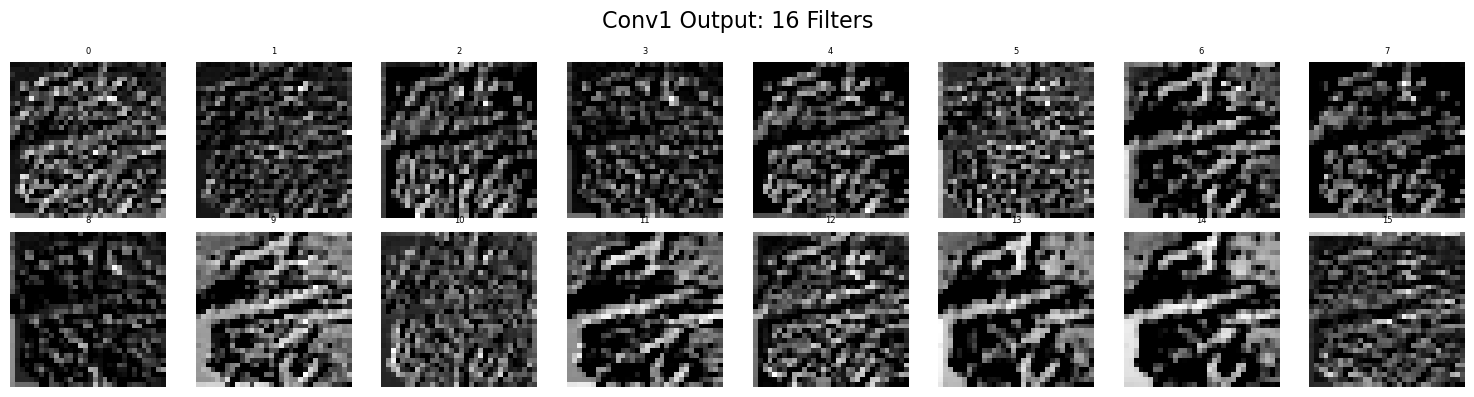

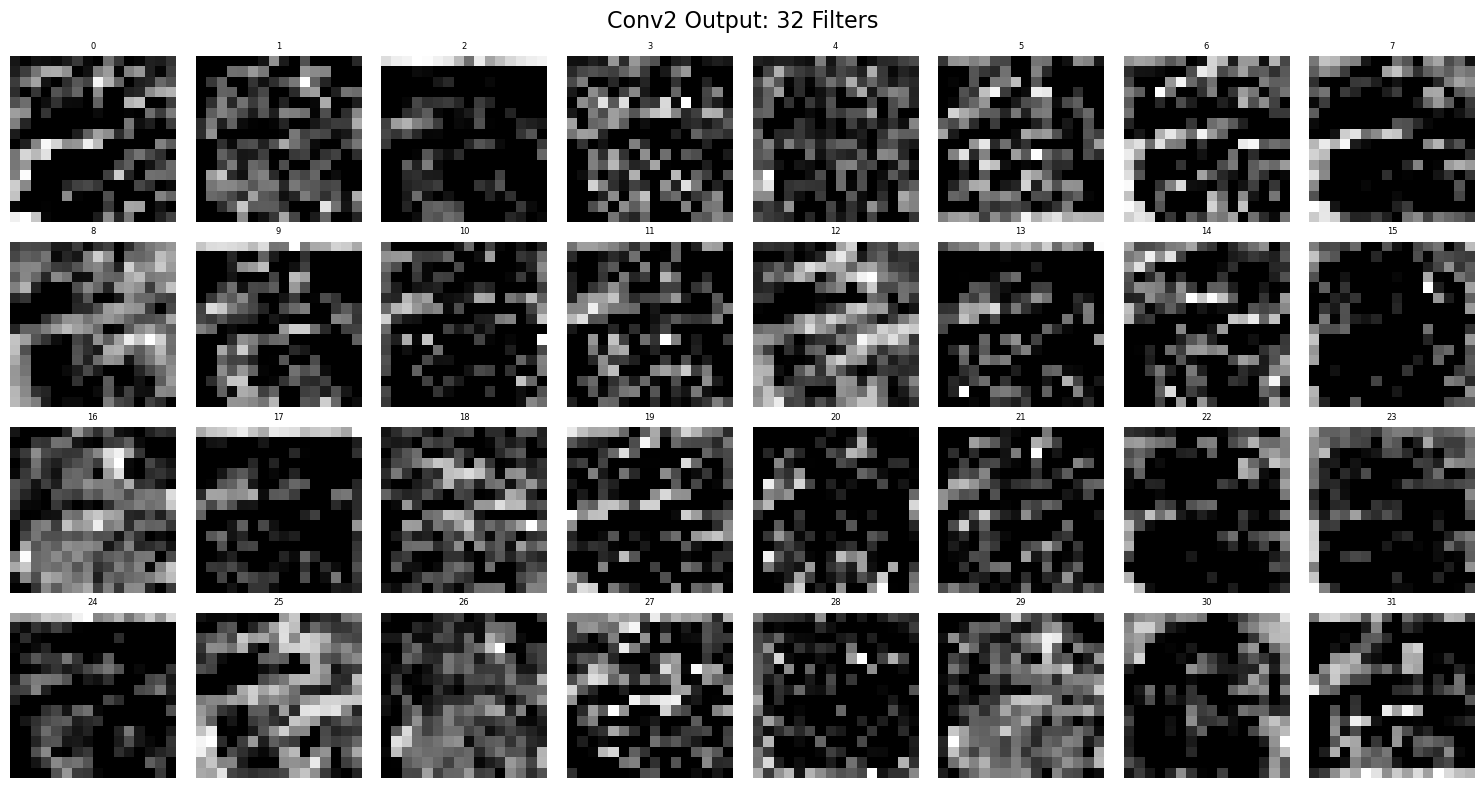

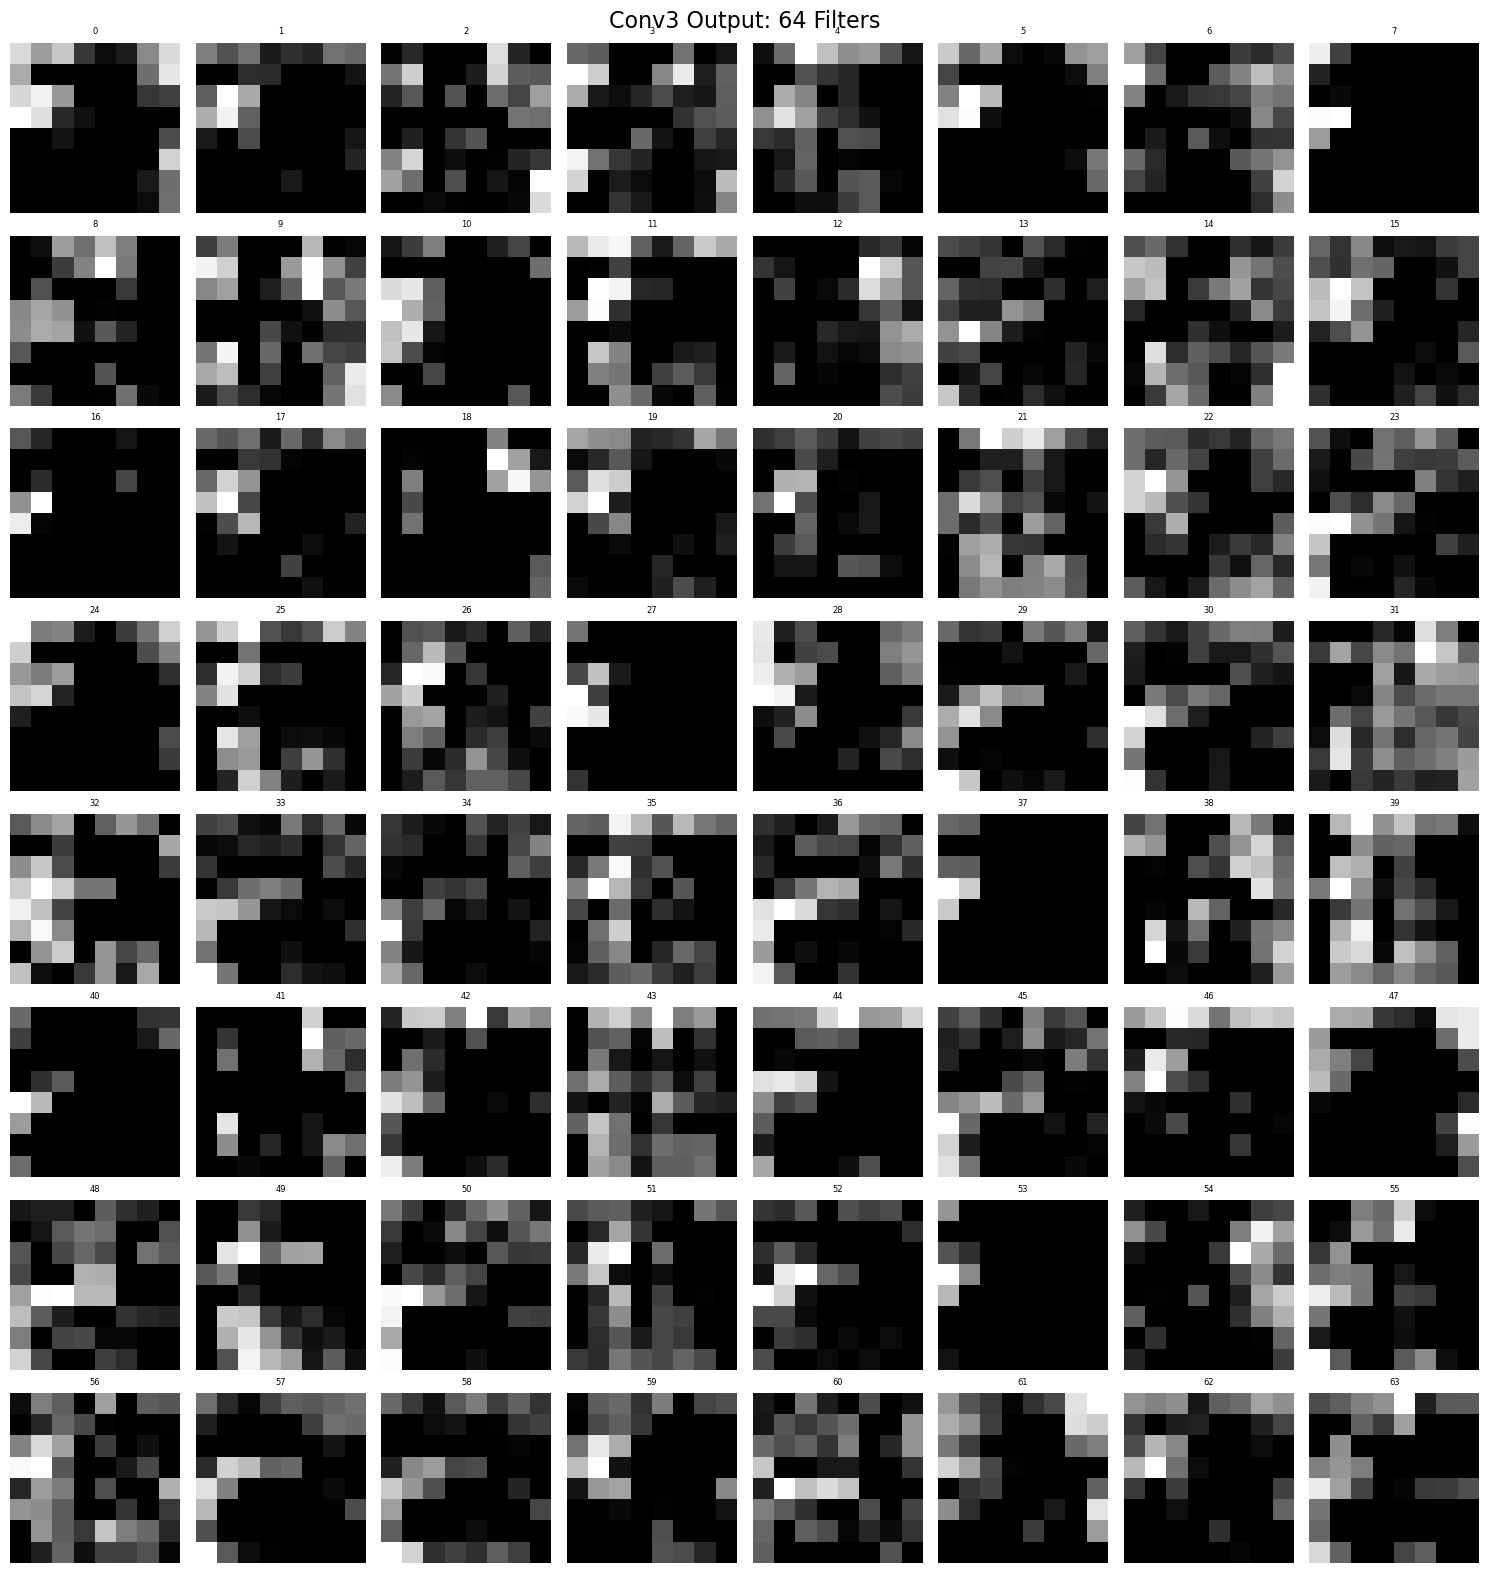

In [46]:
# Find one benign and one adenocarcinoma image
for img, label in train_dataset_full:
    if label == 0:  # Benign
        visualize_all_conv_outputs(img, "Benign")
        break

for img, label in train_dataset_full:
    if label == 1:  # Adenocarcinoma
        visualize_all_conv_outputs(img, "Adenocarcinoma")
        break


/var/folders/q4/n5kvp8wn7g55334d0nyggx500000gn/T/ipykernel_10240/2084582900.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_kfold

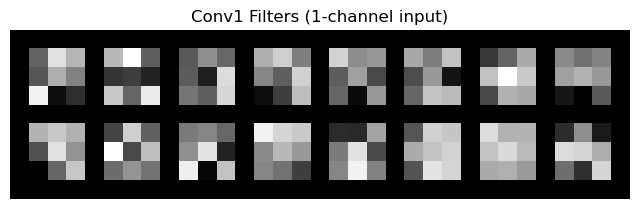

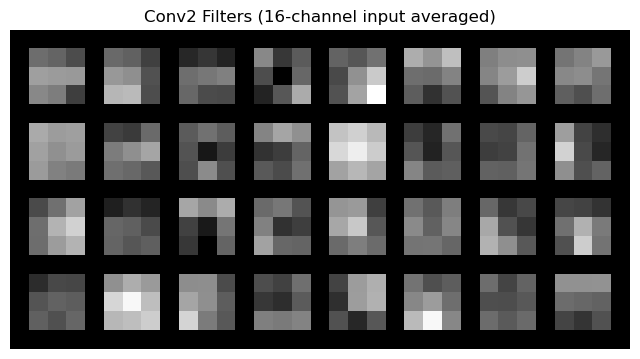

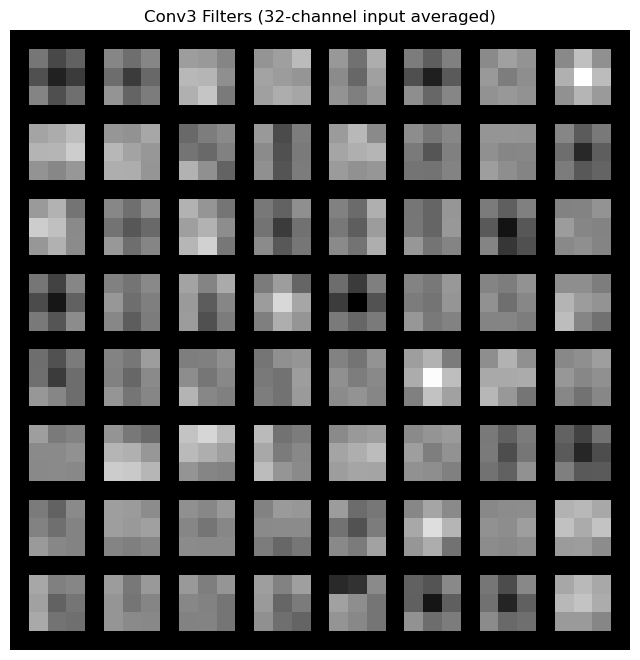

In [65]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def vis_conv_filters(weight_tensor, title, nrow=8, flatten_input=True):
    """
    Visualize learned conv filters.
    - weight_tensor: shape [out_channels, in_channels, H, W]
    - flatten_input: if True, average across input channels
    """
    weights = weight_tensor.clone().detach().cpu()

    if flatten_input:
        weights = weights.mean(dim=1, keepdim=True)  # shape: [out_channels, 1, H, W]

    grid = make_grid(weights, nrow=nrow, normalize=True, padding=1)
    npimg = grid.numpy()

    plt.figure(figsize=(nrow, weights.shape[0] // nrow + 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Load your trained model
model = ImprovedCNN().to(device)
model.load_state_dict(torch.load("best_kfold_model.pth"))
model.eval()

# Visualize filters from Conv1, Conv2, Conv3
vis_conv_filters(model.conv1.weight, "Conv1 Filters (1-channel input)", nrow=8, flatten_input=True)
vis_conv_filters(model.conv2.weight, "Conv2 Filters (16-channel input averaged)", nrow=8, flatten_input=True)
vis_conv_filters(model.conv3.weight, "Conv3 Filters (32-channel input averaged)", nrow=8, flatten_input=True)


In [15]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from kymatio.torch import Scattering2D

# Define MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create scattering object
IMG_SIZE = 64
J = 2
L = 8
scattering = Scattering2D(J=J, shape=(IMG_SIZE, IMG_SIZE), L=L).to(device)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Custom Dataset
class ScatteringDataset(Dataset):
    def __init__(self, image_paths, labels, scattering, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.scattering = scattering
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and apply transform
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)  # [1, 64, 64]

        img = img.to(torch.float32).to(self.device)


        with torch.no_grad():
            Sx = self.scattering(img.unsqueeze(0))  # [1, 81, 16, 16]
            Sx = Sx.squeeze()


        return Sx, label



In [16]:
# Instantiate dataset
scattering_dataset = ScatteringDataset(train_paths, train_labels, scattering, transform=transform, device=device)

# Test it
X, y = scattering_dataset[0]
print("Returned shape:", X.shape)
print("Label:", y)



Returned shape: torch.Size([81, 16, 16])
Label: 0


In [18]:

class ScatNetClassifier(nn.Module):
    def __init__(self, input_dim=81):
        super(ScatNetClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):

        return self.classifier(x)


In [19]:
# ---- Config ----
k = 5
epochs = 10
batch_size = 64

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
indices = np.arange(len(train_paths))
labels_np = np.array(train_labels)

fold_accuracies, fold_f1s = [], []
train_losses_per_epoch, val_losses_per_epoch = [], []
train_accs_per_epoch, val_accs_per_epoch = [], []

# ---- Use only mean pooled features: size [81] ----
input_dim = 81
model_class = ScatNetClassifier(input_dim=input_dim)

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels_np)):
    print(f"\n--- Fold {fold+1} ---")

    train_subset = Subset(scattering_dataset, train_idx)
    val_subset = Subset(scattering_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # New model per fold
    model = ScatNetClassifier(input_dim=input_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # --- Average pooling over spatial dims ---
            X_batch = X_batch.mean(dim=(-1, -2))  # [batch_size, 81]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)
            train_correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)

        # ---- Validation ----
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                X_batch = X_batch.mean(dim=(-1, -2))  # [batch_size, 81]

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item() * X_batch.size(0)
                val_correct += (outputs.argmax(1) == y_batch).sum().item()
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_subset)
        val_acc = val_correct / len(val_subset)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

    fold_accuracies.append(val_acc)
    fold_f1s.append(val_f1)
    train_losses_per_epoch.append(train_losses)
    val_losses_per_epoch.append(val_losses)
    train_accs_per_epoch.append(train_accs)
    val_accs_per_epoch.append(val_accs)

# ---- Summary ----
print(f"\nMean Accuracy across {k} folds: {np.mean(fold_accuracies):.4f}")
print(f"Mean F1 Score across {k} folds: {np.mean(fold_f1s):.4f}")



--- Fold 1 ---
Epoch 1/10 - Train Loss: 0.6069, Train Acc: 0.7184 | Val Loss: 0.4266, Val Acc: 0.8544, Val F1: 0.8524
Epoch 2/10 - Train Loss: 0.3896, Train Acc: 0.8386 | Val Loss: 0.3369, Val Acc: 0.8625, Val F1: 0.8623
Epoch 3/10 - Train Loss: 0.3512, Train Acc: 0.8553 | Val Loss: 0.3252, Val Acc: 0.8706, Val F1: 0.8692
Epoch 4/10 - Train Loss: 0.3382, Train Acc: 0.8614 | Val Loss: 0.3091, Val Acc: 0.8731, Val F1: 0.8731
Epoch 5/10 - Train Loss: 0.3291, Train Acc: 0.8609 | Val Loss: 0.2945, Val Acc: 0.8850, Val F1: 0.8847
Epoch 6/10 - Train Loss: 0.3234, Train Acc: 0.8655 | Val Loss: 0.2868, Val Acc: 0.8850, Val F1: 0.8845
Epoch 7/10 - Train Loss: 0.3208, Train Acc: 0.8689 | Val Loss: 0.2813, Val Acc: 0.8912, Val F1: 0.8908
Epoch 8/10 - Train Loss: 0.3107, Train Acc: 0.8719 | Val Loss: 0.2750, Val Acc: 0.8912, Val F1: 0.8909
Epoch 9/10 - Train Loss: 0.3079, Train Acc: 0.8775 | Val Loss: 0.2780, Val Acc: 0.8962, Val F1: 0.8956
Epoch 10/10 - Train Loss: 0.3057, Train Acc: 0.8772 | Val

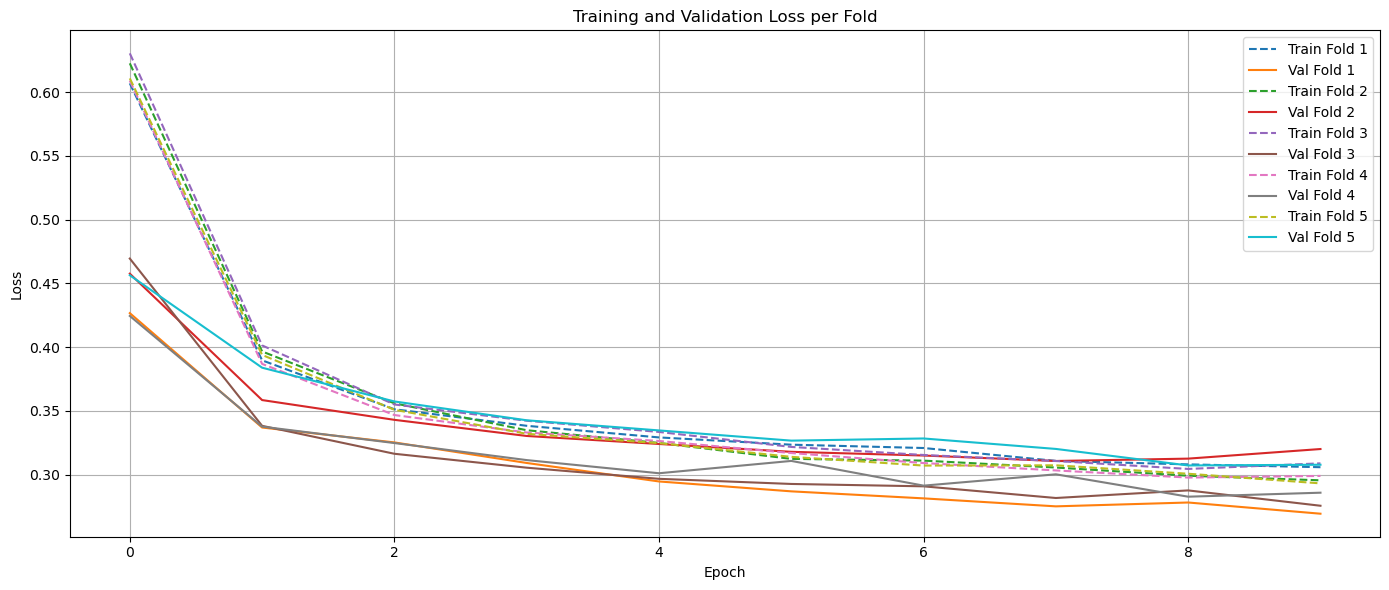

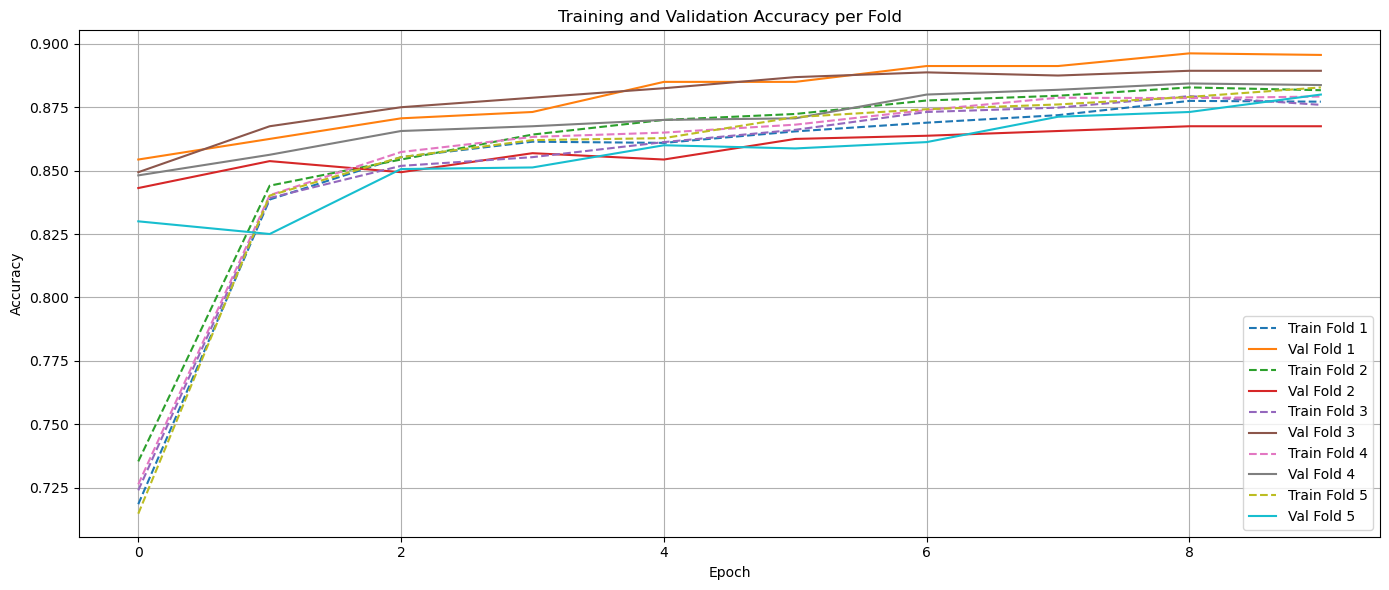

In [20]:
import matplotlib.pyplot as plt

# ---- Plotting Loss Curves ----
plt.figure(figsize=(14, 6))
for i in range(k):
    plt.plot(train_losses_per_epoch[i], label=f"Train Fold {i+1}", linestyle='--')
    plt.plot(val_losses_per_epoch[i], label=f"Val Fold {i+1}")
plt.title("Training and Validation Loss per Fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plotting Accuracy Curves ----
plt.figure(figsize=(14, 6))
for i in range(k):
    plt.plot(train_accs_per_epoch[i], label=f"Train Fold {i+1}", linestyle='--')
    plt.plot(val_accs_per_epoch[i], label=f"Val Fold {i+1}")
plt.title("Training and Validation Accuracy per Fold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


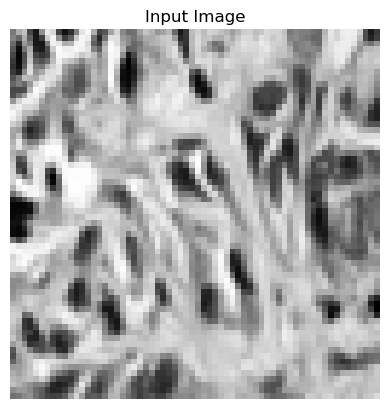

Scattering output shape: torch.Size([1, 1, 81, 16, 16])


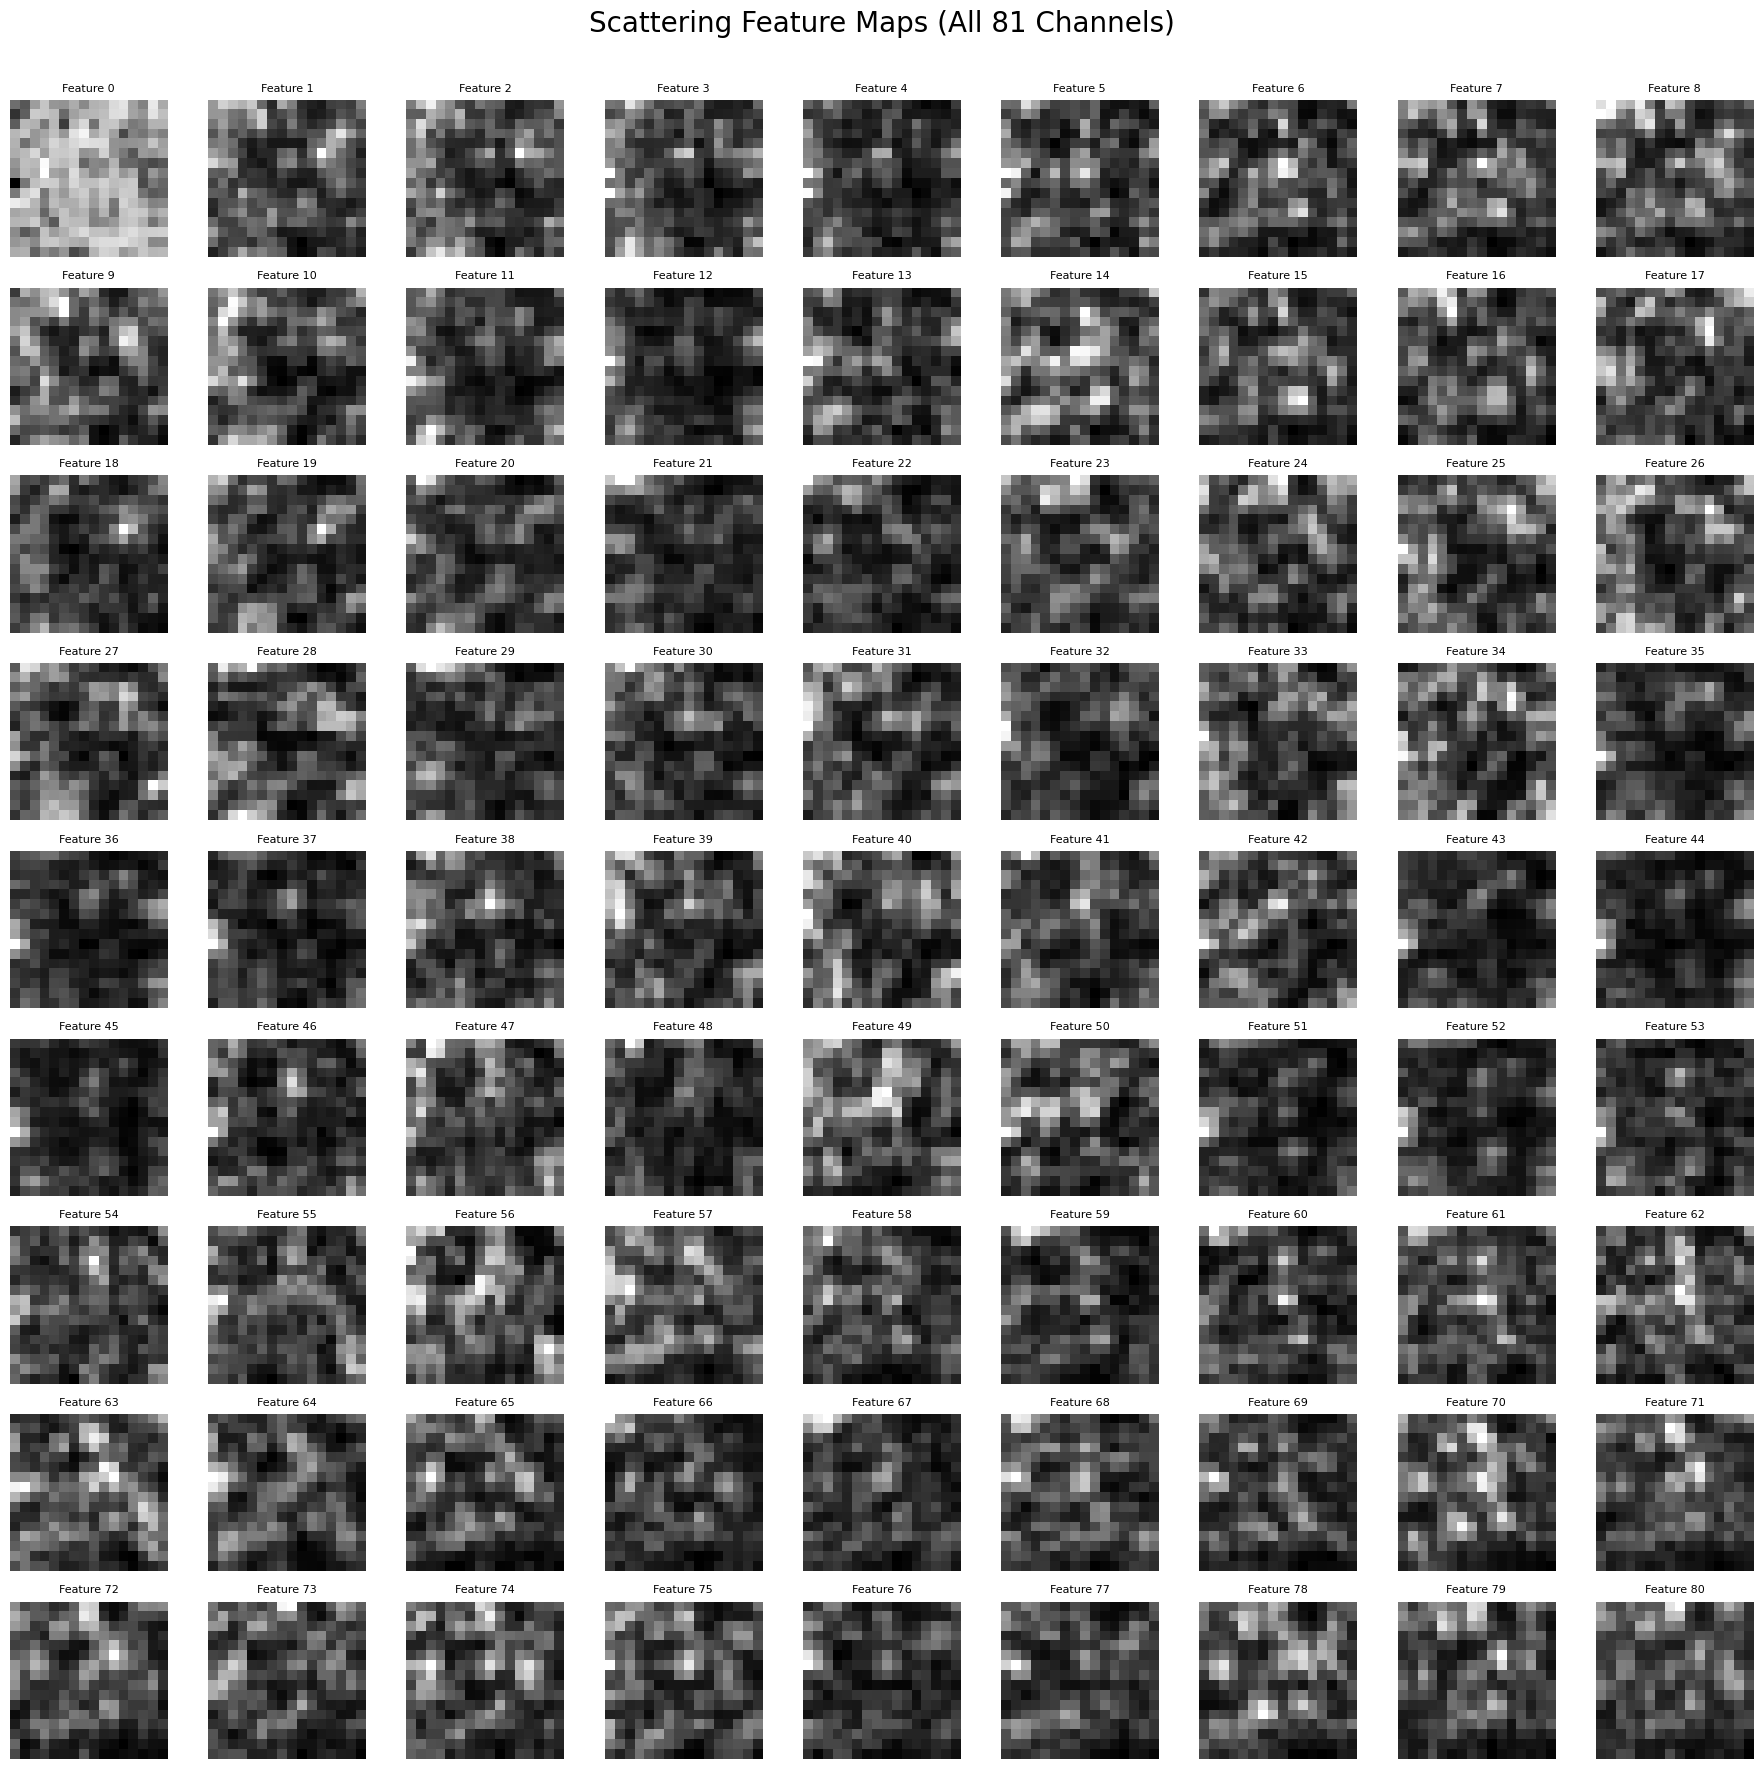

In [11]:
# ----- Step 1: Load a grayscale image -----
img_path = "/Users/sogandghasemi/Documents/uni/VI/Project/archive-4/adenocarcinoma/0001.jpg"  # Replace with your own image
img = Image.open(img_path).convert('L')  # Convert to grayscale
img = img.resize((64, 64))               # Resize to (64, 64)

# Visualize original image
plt.imshow(img, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

# ----- Step 2: Prepare image tensor -----
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to shape [1, H, W], range [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])
x = transform(img).unsqueeze(0)          # Add batch dimension → [1, 1, 64, 64]

# ----- Step 3: Define Scattering Transform -----
J = 2
L = 8
scattering = Scattering2D(J=J, shape=(64, 64), L=L)
x = x.to(torch.float32)                 # Make sure dtype is float32
Sx = scattering(x)                      # Output: [1, C, 16, 16]
print("Scattering output shape:", Sx.shape)

Sx_np = Sx.squeeze().cpu().numpy()  # shape: (81, 16, 16)

# Create a grid of 9 rows × 9 columns = 81 channels
fig, axs = plt.subplots(9, 9, figsize=(18, 18))
fig.suptitle("Scattering Feature Maps (All 81 Channels)", fontsize=20)

for i in range(81):
    ax = axs[i // 9, i % 9]
    ax.imshow(Sx_np[i], cmap='gray')
    ax.set_title(f"Feature {i}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Leave space for title
plt.show()


In [29]:
# Average each feature map (16x16) → single scalar
feature_vector = Sx.mean(dim=(-1, -2))  # shape: [1, 81]
feature_vector = feature_vector.squeeze(0)  # shape: [81]
print("Final feature vector shape:", feature_vector.shape)
feature_vector


Final feature vector shape: torch.Size([1, 81])


tensor([[0.0810, 0.0477, 0.0370, 0.0313, 0.0297, 0.0330, 0.0407, 0.0522, 0.0557,
         0.0651, 0.0509, 0.0448, 0.0486, 0.0492, 0.0550, 0.0708, 0.0780, 0.0066,
         0.0057, 0.0047, 0.0043, 0.0042, 0.0044, 0.0050, 0.0065, 0.0052, 0.0052,
         0.0050, 0.0043, 0.0036, 0.0035, 0.0037, 0.0045, 0.0037, 0.0043, 0.0049,
         0.0044, 0.0033, 0.0029, 0.0032, 0.0033, 0.0030, 0.0033, 0.0041, 0.0048,
         0.0040, 0.0030, 0.0029, 0.0030, 0.0034, 0.0031, 0.0035, 0.0044, 0.0049,
         0.0044, 0.0039, 0.0036, 0.0043, 0.0038, 0.0037, 0.0042, 0.0050, 0.0057,
         0.0057, 0.0055, 0.0057, 0.0046, 0.0044, 0.0047, 0.0054, 0.0064, 0.0077,
         0.0077, 0.0066, 0.0051, 0.0046, 0.0049, 0.0052, 0.0059, 0.0071, 0.0082]])

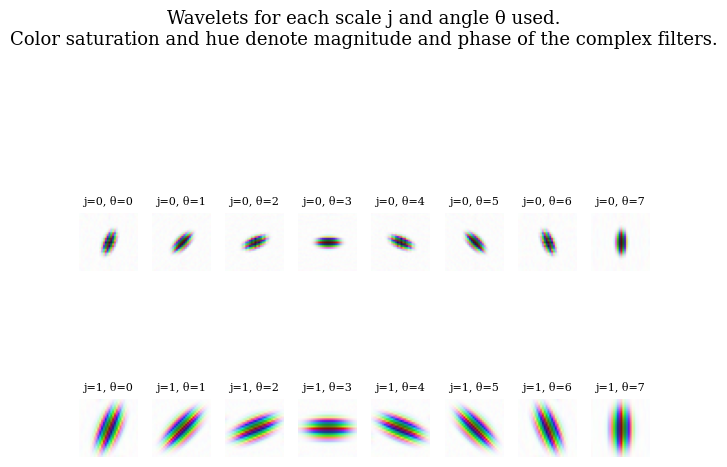

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2
from kymatio.scattering2d.filter_bank import filter_bank
from colorsys import hls_to_rgb

# -------- Custom colorize function --------
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2 * np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 / (1.0 + abs(z[idx]) ** 0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

# -------- Filter Parameters --------
M = 32
J = 2
L = 8

filters_set = filter_bank(M, M, J, L=L)

# -------- Plot wavelet filters --------
fig, axs = plt.subplots(J, L, sharex=True, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(6)
plt.rc('font', family='serif')

i = 0
for filt in filters_set['psi']:
    f = filt["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axs[i // L, i % L].imshow(colorize(filter_c))
    axs[i // L, i % L].axis('off')
    axs[i // L, i % L].set_title(f"j={i // L}, θ={i % L}", fontsize=8)
    i += 1

fig.suptitle((
    "Wavelets for each scale j and angle θ used.\n"
    "Color saturation and hue denote magnitude and phase of the complex filters."
), fontsize=13)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


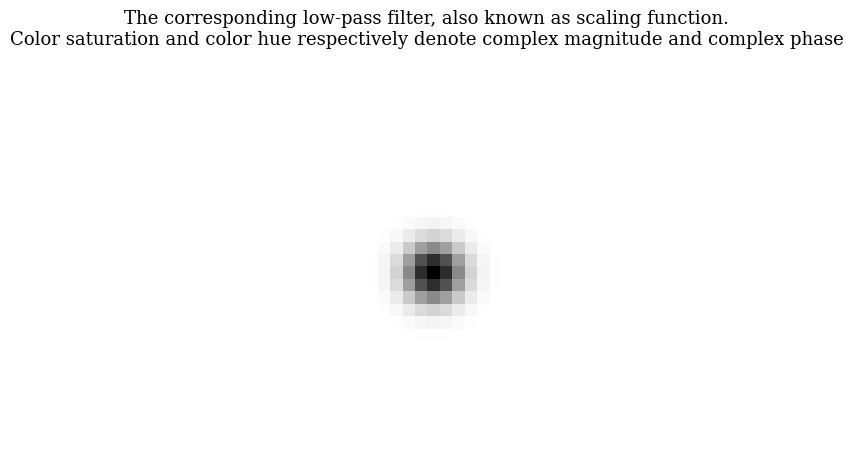

In [38]:
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi']["levels"][0]

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
plt.suptitle(("The corresponding low-pass filter, also known as scaling "
              "function.\nColor saturation and color hue respectively denote "
              "complex magnitude and complex phase"), fontsize=13)
filter_c = np.abs(filter_c)
plt.imshow(filter_c)

plt.tight_layout()
plt.show()